# Example: Lorenz-96 from zhang2021langevinized

## Define the Lorenz-96 model solved by RK4.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the Lorenz 96 model with constant forcing
def lorenz96(x, F=8):
    """Lorenz 96 model with constant forcing."""
    N = len(x)
    dxdt = np.zeros(N)
    for i in range(N):
            if i == 0:
                dxdt[i] = (x[1] -x[N-2]) * x[N-1] - x[i] + F
            elif i == 1:
                dxdt[i] = (x[i+1] - x[N-1]) * x[0] - x[i] + F
            elif i == N - 1:
                dxdt[i] = (x[0] - x[i-2]) * x[i-1] - x[i] + F
            else:
                dxdt[i] = (x[i + 1] - x[i - 2]) * x[i - 1] - x[i] + F
    return dxdt

# RK4 integration step function
def rk4_step(func, x, dt, *args):
    """Runge-Kutta 4th order integration step."""
    k1 = dt * func(x, *args)
    k2 = dt * func(x + 0.5 * k1, *args)
    k3 = dt * func(x + 0.5 * k2, *args)
    k4 = dt * func(x + k3, *args)
    return x + (k1 + 2 * k2 + 2 * k3 + k4) / 6


## Implement EnKF
First define a function for EnKF.

In [61]:
# Function for the EnKF
def EnKF(ensemble, observations, H, process_noise_std, obs_noise_std, num_ensemble, timesteps, dt, inflation): 
    # Create two lists to store the estimated states and ensemble standard deviations
    estimated_states = []
    ensemble_std_dev = []
    ensemble_mean = np.mean(ensemble, axis=0)
    estimated_states.append(ensemble_mean)
    ensemble_std_dev.append(np.std(ensemble, axis=0))

    for t in range(timesteps):
        # Forecast Step: propagate each ensemble member
        for i in range(num_ensemble):
            process_noise = np.random.normal(0, process_noise_std, state_dim)
            ensemble[i] = rk4_step(lorenz96, ensemble[i], dt, 8) + process_noise

        # Calculate ensemble mean and deviations
        ensemble_mean = np.mean(ensemble, axis=0)
        deviations = ensemble - ensemble_mean

        
        # Calculate observation ensemble and deviations
        obs_ensemble = H @ ensemble.T  # Shape: (obs_dim, num_ensemble)
        obs_ensemble_mean = np.mean(obs_ensemble, axis=1)
        obs_deviations = obs_ensemble - obs_ensemble_mean[:, None]

        # Calculate cross-covariance P_xy
        P_xy = (inflation**2) * (deviations.T @ obs_deviations.T) / (num_ensemble - 1)  # Shape: (state_dim, obs_dim)

        # Calculate observation covariance P_yy
        P_yy = (inflation**2) * (obs_deviations @ obs_deviations.T) / (num_ensemble - 1) + np.eye(obs_dim) * obs_noise_std**2

        # Calculate Kalman Gain
        K = P_xy @ np.linalg.inv(P_yy)

        # Analysis Step: update each ensemble member with observation
        for i in range(num_ensemble):
            observation_noise = np.random.normal(0, obs_noise_std, obs_dim)
            ensemble[i] += K @ (observations[t] + observation_noise - H @ ensemble[i])

        # Store estimated mean state
        ensemble_mean = np.mean(ensemble, axis=0)
        estimated_states.append(ensemble_mean)
        
        # Store the standard deviation of the ensemble for confidence interval calculation
        ensemble_std_dev.append(np.std(ensemble, axis=0))
    return estimated_states, ensemble_std_dev

## Plain EnKF implementation, variance inflation, and 2R
Data were generated according to the parameters in the paper.

In [62]:
MSE_R2_better_than_R = 0
coverage_R2_better_than_R = 0
num_experiments = 100

mse_2R_list = []
mse_R_list = []
coverage_2R_list = []
coverage_R_list = []

for seed in range(800, 800+num_experiments):
    np.random.seed(seed)

    # Set parameters for the Lorenz 96 model
    state_dim = 40          # State dimension for Lorenz 96
    obs_dim = 20            # Number of observations (half of the state is observed)
    num_ensemble = 50       # Number of ensemble members
    timesteps = 100         # Number of timesteps
    dt = 0.01               # Timestep size
    obs_noise_std = 1.0     # Standard deviation of observation noise
    process_noise_std = 1.0   # Standard deviation of process noise

    # Initial state
    x0 = np.random.rand(state_dim) + 20  # Initial true state
    x0[19] = 20.01

    # Observation matrix: randomly select observed state variables
    H = np.zeros((obs_dim, state_dim))
    obs_indices = np.random.choice(state_dim, obs_dim, replace=False)
    for i, idx in enumerate(obs_indices):
            H[i, idx] = 1

    # Generate true states and observations
    true_states = [x0]
    observations = []

    # Integrate the true state forward and generate observations
    for t in range(timesteps):
        process_noise = np.random.normal(0, process_noise_std, state_dim)
        true_state = rk4_step(lorenz96, true_states[-1], dt, 8) + process_noise
        obs = H @ true_state + np.random.normal(0, obs_noise_std, obs_dim)
        true_states.append(true_state)
        observations.append(obs)

    # Convert lists to numpy arrays
    true_states = np.array(true_states)
    observations = np.array(observations)

    # Run the EnKF
    # Generate ensemble members around the initial state
    P_init = np.eye(state_dim) * 1.0
    ensemble = np.random.multivariate_normal(x0, P_init, num_ensemble)

    # Run the EnKF for state estimation
    estimated_states, ensemble_std_dev = EnKF(ensemble, observations, H, process_noise_std, obs_noise_std, num_ensemble, timesteps, dt, inflation=1.0)
    
    # Convert estimated states and standard deviation to numpy arrays
    estimated_states = np.array(estimated_states)
    ensemble_std_dev = np.array(ensemble_std_dev)

    # Calculate 95% confidence interval bounds (mean ± 1.96 * std deviation)
    confidence_interval_upper = estimated_states + 1.96 * ensemble_std_dev
    confidence_interval_lower = estimated_states - 1.96 * ensemble_std_dev

    #############################################
    # Implement EnKF with inlfation
    P_init = np.eye(state_dim) * 1.0
    ensemble = np.random.multivariate_normal(x0, P_init, num_ensemble)

    # Run the EnKF for state estimation
    estimated_states_inflated, ensemble_std_dev_inflated = EnKF(ensemble, observations, H, process_noise_std, obs_noise_std, num_ensemble, timesteps, dt, inflation = 2)

    # Convert estimated states and standard deviation to numpy arrays
    estimated_states_inflated = np.array(estimated_states_inflated)
    ensemble_std_dev_inflated = np.array(ensemble_std_dev_inflated)

    # Calculate 95% confidence interval bounds (mean ± 1.96 * std deviation)
    confidence_interval_upper_inflated = estimated_states_inflated + 1.96 * ensemble_std_dev_inflated
    confidence_interval_lower_inflated = estimated_states_inflated - 1.96 * ensemble_std_dev_inflated

    #############################################
    # Implement EnKF with R = 2R
    R2 = 2 * obs_noise_std
    P_init = np.eye(state_dim) * 1.0
    ensemble = np.random.multivariate_normal(x0, P_init, num_ensemble)

    # Run the EnKF for state estimation
    estimated_states_2R, ensemble_std_dev_2R = EnKF(ensemble, observations, H, process_noise_std, R2, num_ensemble, timesteps, dt, inflation=1.0)

    # Convert estimated states and standard deviation to numpy arrays
    estimated_states_2R = np.array(estimated_states_2R)
    ensemble_std_dev_2R = np.array(ensemble_std_dev_2R)

    # Calculate 95% confidence interval bounds (mean ± 1.96 * std deviation)
    confidence_interval_upper_2R = estimated_states_2R + 1.96 * ensemble_std_dev_2R
    confidence_interval_lower_2R = estimated_states_2R - 1.96 * ensemble_std_dev_2R

    # Coverage probability for each state dimension
    # At each time, if a state dimension is covered by the confidence interval, increment the coverage count for that dimension
    # Divide the coverage count by the total number of timesteps to get the coverage probability

    def compute_coverage_probability(true_states, estimated_states, confidence_interval_lower, confidence_interval_upper):
        coverage_probability = np.zeros(true_states.shape[1])
        for t in range(timesteps + 1):
            for i in range(true_states.shape[1]):
                if true_states[t, i] >= confidence_interval_lower[t, i] and true_states[t, i] <= confidence_interval_upper[t, i]:
                    coverage_probability[i] += 1
        return coverage_probability / (timesteps + 1)

    coverage_probability = compute_coverage_probability(true_states, estimated_states, confidence_interval_lower, confidence_interval_upper)
    coverage_probability_inflated = compute_coverage_probability(true_states, estimated_states_inflated, confidence_interval_lower_inflated, confidence_interval_upper_inflated)
    coverage_probability_2R = compute_coverage_probability(true_states, estimated_states_2R, confidence_interval_lower_2R, confidence_interval_upper_2R)

    
    # Calculate MSE
    def compute_mse(true_values, estimated_values):
        return np.mean((true_values - estimated_values) ** 2)


    # MSE for each state dimension
    mse = compute_mse(true_states, estimated_states)
    mse_inflated = compute_mse(true_states, estimated_states_inflated)
    mse_2R = compute_mse(true_states, estimated_states_2R)

    if mse_2R < mse:
        MSE_R2_better_than_R += 1
    
    if np.mean(coverage_probability_2R) > np.mean(coverage_probability):
            coverage_R2_better_than_R += 1

    mse_2R_list.append(mse_2R)
    mse_R_list.append(mse)
    coverage_2R_list.append(np.mean(coverage_probability_2R))
    coverage_R_list.append(np.mean(coverage_probability))

    # Coverage probability for each state dimension
    print(f'Seed: {seed} ------------------')
    print(f"Coverage Probability forthe first five dimensions:")
    print(f"EnKF: {coverage_probability[0:4]}")
    # print(f"EnKF with Inflation: {coverage_probability_inflated[0:4]}")
    print(f"EnKF with 2R: {coverage_probability_2R[0:4]}")
    print('-----------------------------------')

    print(f"Mean Squared Error (state dimensions):")
    print(f"EnKF MSE: {mse:.2}")
    # print(f"EnKF with Inflation MSE: {mse_inflated:.2}")
    print(f"EnKF with 2R MSE: {mse_2R:.2}")
    print('-----------------------------------')

    # Coverage probability (average over all state dimensions)
    print(f"Average Coverage Probability (over all dimensions):")
    print(f"EnKF: {np.mean(coverage_probability):.2f}")
    # print(f"EnKF with Inflation: {np.mean(coverage_probability_inflated):.2f}")
    print(f"EnKF with 2R: {np.mean(coverage_probability_2R):.2f}")
    print("=====================================")

print(f"Number of times MSE of 2R is better than R: {MSE_R2_better_than_R} out of {num_experiments}")
print(f"Number of times coverage of 2R is better than R: {coverage_R2_better_than_R} out of {num_experiments}")


Seed: 800 ------------------
Coverage Probability forthe first five dimensions:
EnKF: [0.37623762 0.41584158 0.55445545 0.52475248]
EnKF with 2R: [0.28712871 0.31683168 0.68316832 0.44554455]
-----------------------------------
Mean Squared Error (state dimensions):
EnKF MSE: 2.5e+01
EnKF with 2R MSE: 5.4e+01
-----------------------------------
Average Coverage Probability (over all dimensions):
EnKF: 0.62
EnKF with 2R: 0.70
Seed: 801 ------------------
Coverage Probability forthe first five dimensions:
EnKF: [0.83168317 0.85148515 0.22772277 0.22772277]
EnKF with 2R: [0.92079208 0.77227723 0.45544554 0.56435644]
-----------------------------------
Mean Squared Error (state dimensions):
EnKF MSE: 3.2e+01
EnKF with 2R MSE: 2.2e+01
-----------------------------------
Average Coverage Probability (over all dimensions):
EnKF: 0.61
EnKF with 2R: 0.73
Seed: 802 ------------------
Coverage Probability forthe first five dimensions:
EnKF: [0.84158416 0.63366337 0.76237624 0.4950495 ]
EnKF with 

## Plotting the results

In general, EnKF with $2R$ and inflated EnKF have a better uncertainty quantification than the plain EnKF. This is expected sicne EnKF systematically underestimates the posterior covariance. In 289 out of 300 cases, EnKF with $2R$ has the best coverage.

The state estimation (MSEs) of the inflated EnKF was outperformed by EnKF with $2R$ and the plain EnKF. We also noticed that in 204 out of 300 cases, the state estimates of EnKF with $2R$ outperform those of the plain EnKF.

## Plot MSEs and CIs

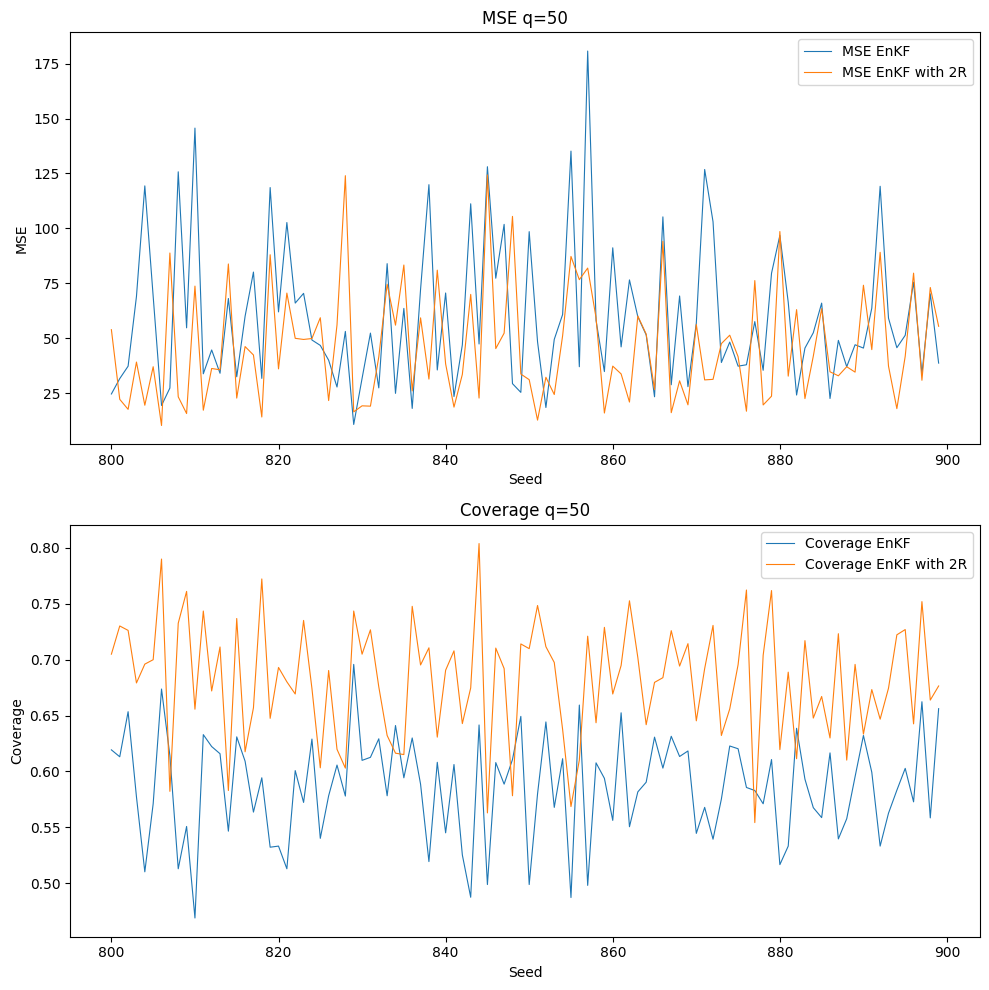

In [63]:
# Plot the MSEs and coverage probabilities
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
seed = range(800, 800+num_experiments)

# Plot data in each subplot
axs[0].plot(seed, mse_R_list, linestyle='-', linewidth=0.8, label="MSE EnKF")
axs[0].plot(seed, mse_2R_list, linestyle='-', linewidth=0.8, label="MSE EnKF with 2R")
axs[0].set_title(f"MSE q={num_ensemble}")
axs[0].set_xlabel("Seed")
axs[0].set_ylabel("MSE")
axs[0].legend()

axs[1].plot(seed, coverage_R_list, linestyle='-', linewidth=0.8, label="Coverage EnKF")
axs[1].plot(seed, coverage_2R_list, linestyle='-', linewidth=0.8, label="Coverage EnKF with 2R")
axs[1].set_title(f"Coverage q={num_ensemble}")
axs[1].set_xlabel("Seed")
axs[1].set_ylabel("Coverage")
axs[1].legend()

plt.tight_layout()
plt.savefig(f"EnKF_MSE_coverage_Lorenz96_q{num_ensemble}.png")
plt.show()

## Plot the results of EnKF and its variants

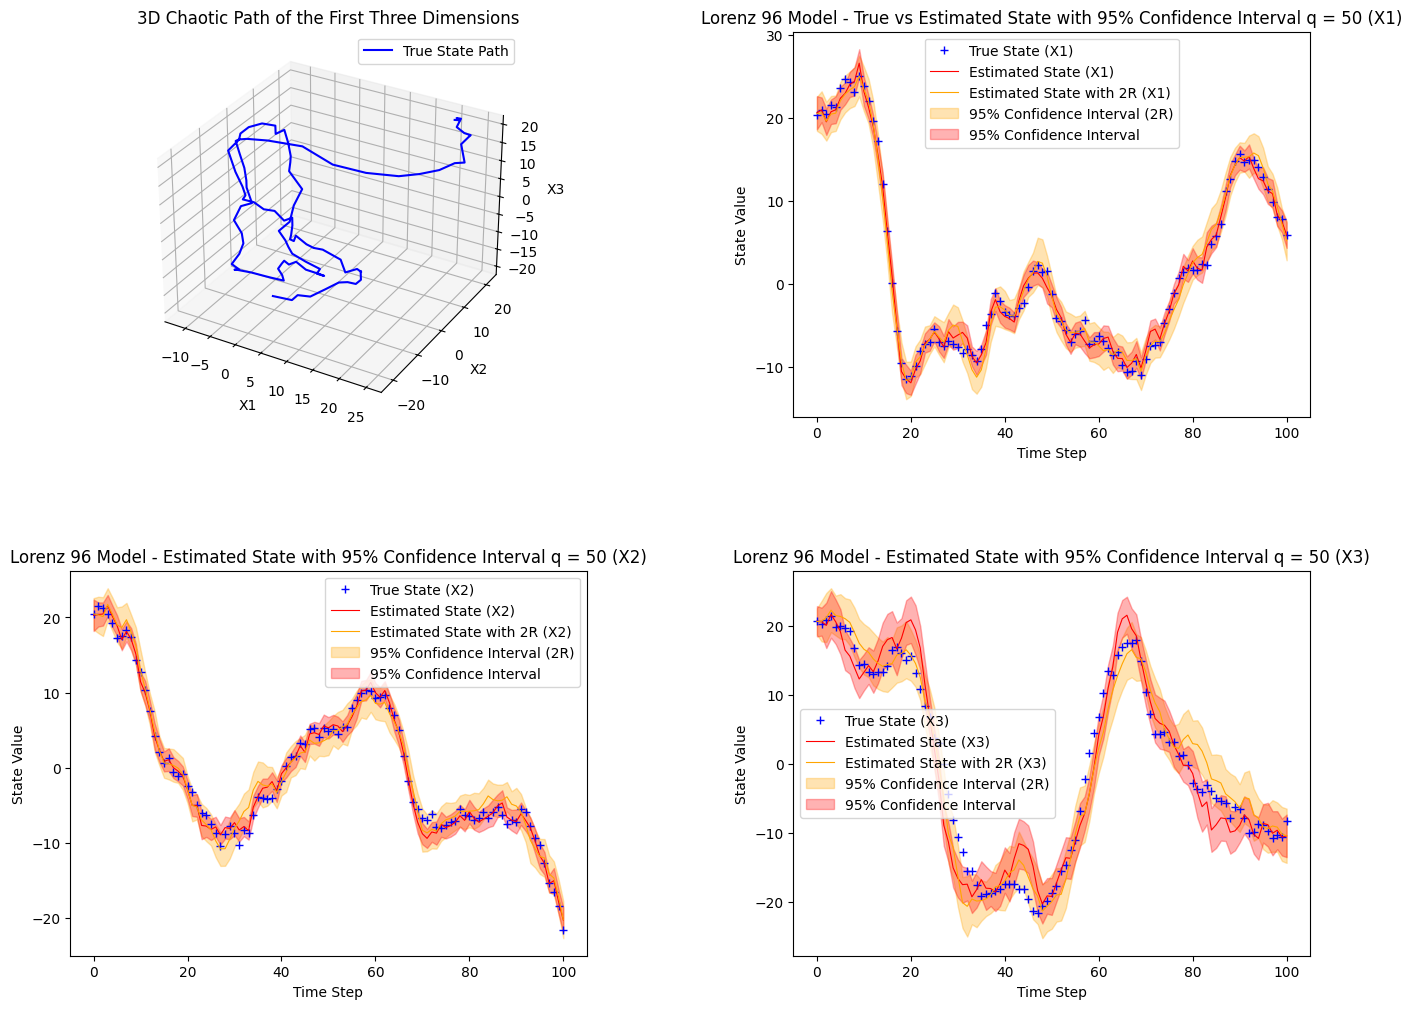

In [64]:
# Plotting
fig = plt.figure(figsize=(16, 12))
grid = plt.GridSpec(2, 2, wspace=0.4, hspace=0.4)

# 3D plot of the first three dimensions
ax1 = fig.add_subplot(grid[0, 0], projection='3d')
ax1.plot(true_states[:, 0], true_states[:, 1], true_states[:, 2], label='True State Path', color='b')
ax1.set_xlabel('X1')
ax1.set_ylabel('X2')
ax1.set_zlabel('X3')
ax1.set_title('3D Chaotic Path of the First Three Dimensions')
ax1.legend()

# Plotting true state vs estimated state with confidence interval for the first dimension
ax2 = fig.add_subplot(grid[0, 1])
ax2.plot(range(timesteps + 1), true_states[:, 0], label='True State (X1)', color='b', marker='+', linestyle='None')
# ax2.plot(range(timesteps + 1), estimated_states_inflated[:, 0], linestyle='-', label='Estimated State with Inflation (X1)', color='g', linewidth=0.8)
ax2.plot(range(timesteps + 1), estimated_states[:, 0], linestyle='-', label='Estimated State (X1)', color='r', linewidth=0.8)
ax2.plot(range(timesteps + 1), estimated_states_2R[:, 0], linestyle='-', label='Estimated State with 2R (X1)', color='orange', linewidth=0.8)
ax2.fill_between(range(timesteps + 1),
                    confidence_interval_lower_2R[:, 0],
                    confidence_interval_upper_2R[:, 0],
                    color='orange', alpha=0.3, label='95% Confidence Interval (2R)')
ax2.fill_between(range(timesteps + 1),
                 confidence_interval_lower[:, 0],
                 confidence_interval_upper[:, 0],
                 color='r', alpha=0.3, label='95% Confidence Interval')
# ax2.fill_between(range(timesteps + 1),
#                  confidence_interval_lower_inflated[:, 0],
#                  confidence_interval_upper_inflated[:, 0],
#                  color='g', alpha=0.3, label='95% Confidence Interval with Inflation (X1)')
ax2.set_xlabel('Time Step')
ax2.set_ylabel('State Value')
ax2.set_title(f'Lorenz 96 Model - True vs Estimated State with 95% Confidence Interval q = {num_ensemble} (X1)')
ax2.legend()

# Plotting estimated state for other dimensions in the 2x2 grid
ax3 = fig.add_subplot(grid[1, 0])
ax3.plot(range(timesteps + 1), true_states[:, 1], label='True State (X2)', color='b', marker='+', linestyle='None')
# ax3.plot(range(timesteps + 1), estimated_states_inflated[:, 1], linestyle='-', label='Estimated State with Inflation (X3)', color='g', linewidth=0.8)
ax3.plot(range(timesteps + 1), estimated_states[:, 1], linestyle='-', label='Estimated State (X2)', color='r', linewidth=0.8)
ax3.plot(range(timesteps + 1), estimated_states_2R[:, 1], linestyle='-', label='Estimated State with 2R (X2)', color='orange', linewidth=0.8)
ax3.fill_between(range(timesteps + 1),
                 confidence_interval_lower_2R[:, 1],
                 confidence_interval_upper_2R[:, 1],
                 color='orange', alpha=0.3, label='95% Confidence Interval (2R)')
ax3.fill_between(range(timesteps + 1),
                 confidence_interval_lower[:, 1],
                 confidence_interval_upper[:, 1],
                 color='r', alpha=0.3, label='95% Confidence Interval')
# ax3.fill_between(range(timesteps + 1),
#                     confidence_interval_lower_inflated[:, 1],
#                     confidence_interval_upper_inflated[:, 1],
#                     color='g', alpha=0.3, label='95% Confidence Interval with Inflation (X2)')
ax3.set_xlabel('Time Step')
ax3.set_ylabel('State Value')
ax3.set_title(f'Lorenz 96 Model - Estimated State with 95% Confidence Interval q = {num_ensemble} (X2)')
ax3.legend()

ax4 = fig.add_subplot(grid[1, 1])
ax4.plot(range(timesteps + 1), true_states[:, 2], label='True State (X3)', color='b', marker='+', linestyle='None')
# ax4.plot(range(timesteps + 1), estimated_states_inflated[:, 2], linestyle='-', label='Estimated State with Inflation (X3)', color='g', linewidth=0.8)
ax4.plot(range(timesteps + 1), estimated_states[:, 2], linestyle='-', label='Estimated State (X3)', color='r', linewidth=0.8)
ax4.plot(range(timesteps + 1), estimated_states_2R[:, 2], linestyle='-', label='Estimated State with 2R (X3)', color='orange', linewidth=0.8)
ax4.fill_between(range(timesteps + 1),
                 confidence_interval_lower_2R[:, 2],
                 confidence_interval_upper_2R[:, 2],
                 color='orange', alpha=0.3, label='95% Confidence Interval (2R)')
ax4.fill_between(range(timesteps + 1),
                 confidence_interval_lower[:, 2],
                 confidence_interval_upper[:, 2],
                 color='r', alpha=0.3, label='95% Confidence Interval')
# ax4.plot(range(timesteps + 1), estimated_states_inflated[:, 2], linestyle='-', label='Estimated State with Inflation (X3)', color='g', linewidth=0.8)
# ax4.fill_between(range(timesteps + 1),
#                  confidence_interval_lower_inflated[:, 2],
#                  confidence_interval_upper_inflated[:, 2],
#                  color='g', alpha=0.3, label='95% Confidence Interval with Inflation (X3)')
ax4.set_xlabel('Time Step')
ax4.set_ylabel('State Value')
ax4.set_title(f'Lorenz 96 Model - Estimated State with 95% Confidence Interval q = {num_ensemble} (X3)')
ax4.legend()

plt.savefig(f"EnKF_Example3_q{num_ensemble}.png")
plt.show()


## Visualize the coverage probabilities for different dimensions in a dataset

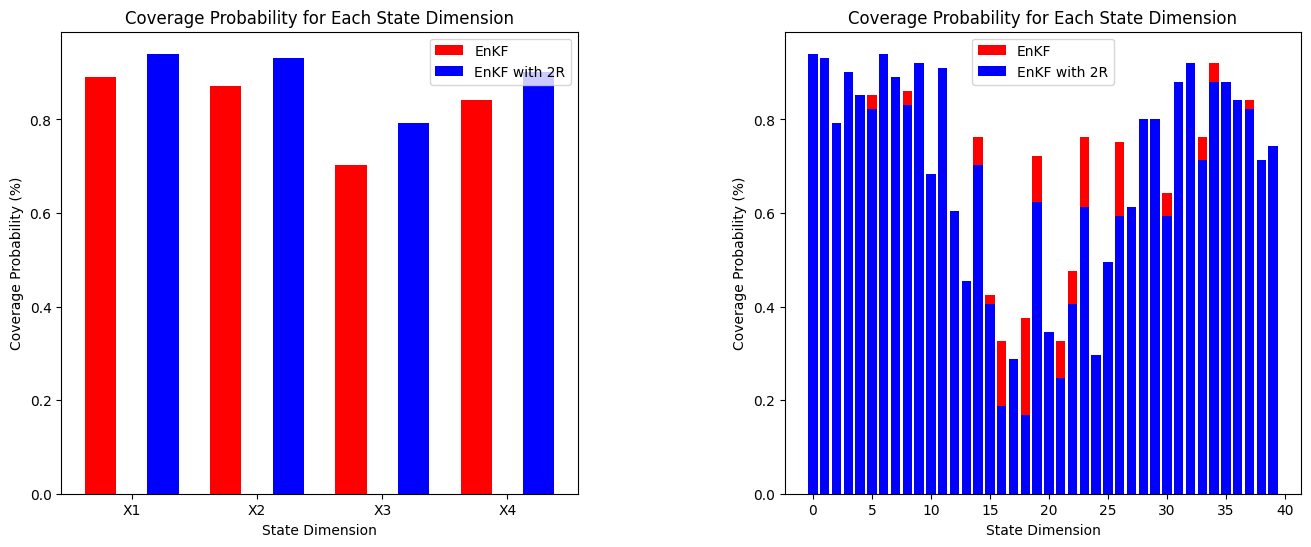

In [65]:
# Plot the coverage probability for each state dimension
# side-by-side bar plot and separate bar plot for each state dimension
fig = plt.figure(figsize=(16, 6))
grid = plt.GridSpec(1, 2, wspace=0.4)

ax1 = fig.add_subplot(grid[0])
bar_width = 0.25
bar_positions = np.arange(4)
ax1.bar(bar_positions, coverage_probability[0:4], bar_width, label='EnKF', color='r')
ax1.bar(bar_positions + 2 * bar_width, coverage_probability_2R[0:4], bar_width, label='EnKF with 2R', color='b')
# ax1.bar(bar_positions + bar_width, coverage_probability_inflated[0:4], bar_width, label='EnKF with Inflation', color='g')
ax1.set_xlabel('State Dimension')
ax1.set_ylabel('Coverage Probability (%)')
ax1.set_title('Coverage Probability for Each State Dimension')
ax1.set_xticks(bar_positions + bar_width)
ax1.set_xticklabels(['X1', 'X2', 'X3', 'X4'])
ax1.legend()

ax2 = fig.add_subplot(grid[1])
bar_positions = np.arange(40)
ax2.bar(bar_positions, coverage_probability, label='EnKF', color='r')
ax2.bar(bar_positions, coverage_probability_2R, label='EnKF with 2R', color='b')
# ax2.bar(bar_positions, coverage_probability_inflated, label='EnKF with Inflation', color='g')
ax2.set_xlabel('State Dimension')
ax2.set_ylabel('Coverage Probability (%)')
ax2.set_title('Coverage Probability for Each State Dimension')
ax2.legend()

plt.savefig("EnKF_coverage_probability_Example3.png")
plt.show()